In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math 
import numpy as np
from torch.utils.data import Dataset,DataLoader
import matplotlib.pyplot as plt


In [2]:
#实现位置编码
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=5000):
        """ 
        d_model: 输入的维度
        max_len: 最长的序列长度
        """
        super(PositionalEncoding,self).__init__()
        # 初始化位置编码
        pe=torch.zeros(max_len,d_model)
        position=torch.arange(0,max_len,dtype=torch.float)
        position=position.reshape(max_len,1)

        #计算位置编码的分母部分
        div_term=torch.exp(torch.arange(0,d_model,2).float()*(-math.log(10000.0)/d_model))

        #完成位置编码矩阵的填充计算
        pe[:,0::2]=torch.sin(position*div_term) #偶数列
        pe[:,1::2]=torch.cos(position*div_term) #奇数列

        #将位置编码矩阵固定住，不进行梯度计算
        pe=pe.unsqueeze(0).transpose(0,1)
        self.register_buffer('pe',pe)
    def forward(self,x):
        """
        x: [seq_len,batch_size,d_model]
        """
        return x+self.pe[:x.size(0),:]

In [3]:
class SimpleTransformer(nn.Module):
    def __init__(self,vocab_size,d_model,nhead,num_layers,dim_feedforward,dropout=0.1):
        """  
        vocab_size:词汇表大小
        d_model:输入和输出的维度
        nhead:多头注意力的头数
        num_layers:编码器的层数
        dim_feedforward:前馈网络的维度
        dropout:丢弃概率
        """
        super(SimpleTransformer,self).__init__()
        self.model_type='Transformer'
        self.d_model=d_model

        #词嵌入层
        self.embedding=nn.Embedding(vocab_size,d_model)
        #位置编码层
        self.pos_encoder=PositionalEncoding(d_model)
        #transformer编码器
        encoder_layers=nn.TransformerEncoderLayer(d_model,nhead,dim_feedforward=dim_feedforward,dropout=dropout,batch_first=False)
        #transformer编码器堆叠
        self.transformer_encoder=nn.TransformerEncoder(encoder_layer=encoder_layers,num_layers=num_layers)
        #输出层
        self.decoder=nn.Linear(d_model,vocab_size)

        self.init_weights()

    def init_weights(self):
        """初始化模型的参数权重"""
        initrange=0.1
        self.embedding.weight.data.uniform_(-initrange,initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange,initrange)
    def forward(self,src,src_mask=None):
        """ 
        src:输入序列,shape=(seq_len,batch_size)
        src_mask:输入序列的mask,shape=(seq_len,seq_len) 原序列的掩码，用于防止模型看到未来的信息
        """
        #将词嵌入并进行缩放
        src=self.embedding(src)*math.sqrt(self.d_model)

        #添加位置编码
        src=self.pos_encoder(src)
        #通过编码层进行编码
        output=self.transformer_encoder(src,src_mask)
        output=self.decoder(output)
        return output


In [4]:
#生成掩码函数
def generate_square_subsequent_mask(sz):
    """用于生成square mask,即对角线及对角线以上的元素为0,否则为1
    参数：
    sz: int, mask的尺寸
    """
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

In [5]:
#创建简单的数据用于测试
class SimpleDataset(Dataset):
    def __init__(self,data,targets):
        self.data=data 
        self.targets=targets

    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        return self.data[index],self.targets[index]

In [6]:
def generate_sample_data(num_samples=1000,seq_length=20,vocab_size=100):
    """生成样本数据用于训练
    参数：
    num_samples:样本数量
    seq_length:序列长度
    vocab_size:字典大小
    """
    data=torch.randint(0,vocab_size,(num_samples,seq_length))
    targets=torch.roll(data,shifts=-1,dims=1)
    targets[:,-1]=0

    return data,targets

In [7]:
train_data,train_targets=generate_sample_data(num_samples=1000,seq_length=20,vocab_size=100)
train_dataset=SimpleDataset(train_data,train_targets)
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)

In [8]:
vocab_size=100
d_model=128
nhead=8
num_layers=2
dim_feedforward=512
dropout=0.1

model=SimpleTransformer(
    vocab_size=vocab_size,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    dropout=dropout
)

criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(), lr=0.001)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=model.to(device)

/Applications/app_for_code/miniconda3/envs/nlp/lib/python3.12/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
def train_model(model,train_loader,criterion,optimizer,num_epochs=10):
    """参数含义：
    model: 模型
    train_loader: 训练数据集
    criterion: 损失函数
    optimizer: 优化器
    num_epochs: 训练轮数
    """
    model.train()

    losses=[]
    for epoch in range(num_epochs):
        total_loss=0
        for batch_idx,(data,target) in enumerate(train_loader):
            data=data.transpose(0,1).to(device)
            target=target.transpose(0,1).to(device)

            optimizer.zero_grad()
            output=model(data)
            loss=criterion(output.reshape(-1, output.size(-1)), target.reshape(-1))
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
        avg_loss=total_loss/len(train_loader)
        losses.append(avg_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, avg_loss))
    return losses 
print("Training started...")
losses=train_model(model=model,train_loader=train_loader,criterion=criterion,optimizer=optimizer,num_epochs=10)

Training started...
Epoch [1/10], Loss: 4.5231
Epoch [2/10], Loss: 4.3304
Epoch [3/10], Loss: 3.7431
Epoch [4/10], Loss: 1.8412
Epoch [5/10], Loss: 0.2556
Epoch [6/10], Loss: 0.0567
Epoch [7/10], Loss: 0.0323
Epoch [8/10], Loss: 0.0241
Epoch [9/10], Loss: 0.0186
Epoch [10/10], Loss: 0.0160


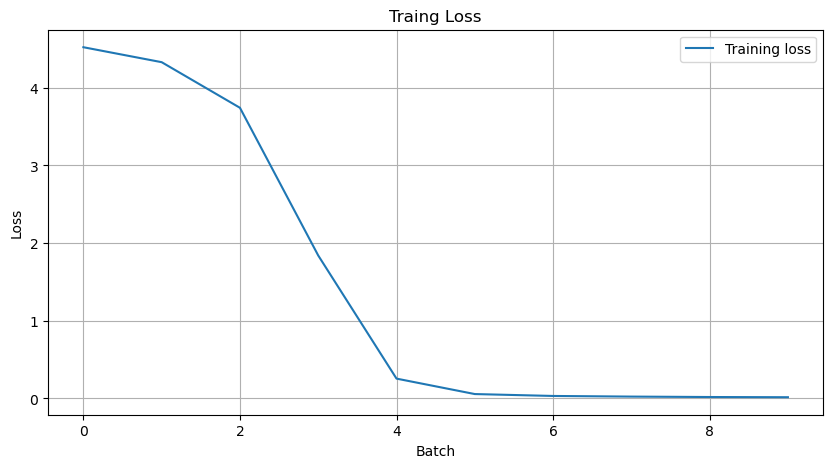

In [13]:
#可视化损失曲线图
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training loss')
plt.title("Traing Loss")
plt.legend()
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [14]:
def test_model(model,test_data):
    """
    测试模型
    model: 模型
    test_loader: 测试数据
    """
    model.eval()
    with torch.no_grad():
        test_data=test_data.transpose(0,1).to(device)

        output=model(test_data)
        predicted=torch.argmax(output,dim=1)
        return predicted
    
test_data,test_target=generate_sample_data(num_samples=5,seq_length=20,vocab_size=100)
predicted=test_model(model,test_data)
# 显示结果
print("测试结果:")
print("输入序列:")
print(test_data[:, 0].cpu().numpy())
print("真实目标:")
print(test_target[:, 0].cpu().numpy())
print("模型预测:")
print(predicted[:, 0].cpu().numpy())

测试结果:
输入序列:
[11 85 90 38 37]
真实目标:
[37 53  9 26 23]
模型预测:
[0 0 2 3 0 3 3 1 1 0 0 3 0 4 2 0 2 1 3 4]
